In [114]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import numpy as np
from PIL import Image
import configparser

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.predict import *
from models.train_utils import *
from models.evaluation_utils import *


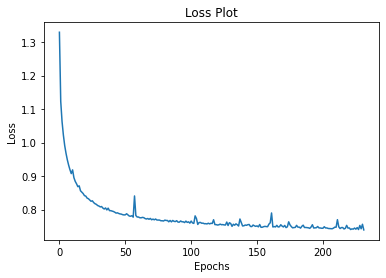

In [2]:
loss_plot = load_loss()
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [3]:
units = int(config['config']['units'])
embedding_dim = int(config['config']['embedding_dim'])
use_glove = bool(config['config']['use_glove'])

In [4]:
val_image_paths, image_path_to_caption = import_files(shuffle= False, method = "val")

val_captions = []
img_name_vector = []
for image_path in val_image_paths:
  caption_list = image_path_to_caption[image_path]
  val_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

5000


In [5]:
train_image_paths, image_path_to_caption_train = import_files(shuffle= False, method = "train")

train_captions = []
img_name_vector_train = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption_train[image_path]
  train_captions.extend(caption_list)
  img_name_vector_train.extend([image_path] * len(caption_list))

60000


In [6]:
_, _, vocabulary, _ = load_dataset()

In [7]:
word_to_index_val, index_to_word_val, tokenizer_val, cap_vector_val = tokenization(val_captions, max_length, 40000)

In [8]:
word_to_index_train, index_to_word_train, tokenizer_train, cap_vector_train = tokenization(train_captions, max_length, 400000)

In [9]:
embeddings_index = {}

if use_glove:
    glove_path = "./dataset/glove.6B/glove.6B.100d.txt"

    
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    vocabulary = tokenizer_train.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))

    num_tokens = len(vocabulary) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 17160 words (15228 misses)


In [10]:
encoder = CNN_Encoder(embedding_dim)
if use_glove:
    decoder = RNN_Decoder(embedding_dim, units, num_tokens, embedding_matrix)
else:
    decoder = RNN_Decoder(embedding_dim, units, tokenizer_train.vocabulary_size(), None)
image_features_extract_model = get_feature_extractor()

In [11]:
img_name_val, cap_val = split_data(img_name_vector, cap_vector_val ,
                                    image_features_extract_model, 1)

100%|██████████| 157/157 [00:31<00:00,  5.00it/s]


In [12]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [77]:
for i in range(10):
    print(' '.join([tf.compat.as_text(index_to_word_val(j).numpy())
                         for j in cap_val[i] if j not in [0]]).split('<start>')[1].split('<end>')[0])

 a nearly empty plate containing broccoli and brown sauce. 
 a plate is left sitting half eaten with mostly broccoli remaining. 
 a half eaten plate of food sits on the table. 
 a plate sits on a table mostly empty, except for a few vegetables. 
 broccoli, carrots and a small amount of potatoes on a plate. 
 a man getting ready to throw a frisbee on a field. 
 a guy with a racket playing tennis on the court 
 a man standing on top of a grass covered field with a frisbee. 
 a man who is jumping up to catch a frisbee. 
 a man holding a frisbee in his hand in a field. 


In [78]:
references = []
list_of_references = []

for i in range(len(img_name_val)):
    references.append(' '.join([tf.compat.as_text(index_to_word_val(j).numpy())
                                for j in cap_val[i] if j not in [0]]).split('<start>')[1].split('<end>')[0])
    
for i in range(0, len(img_name_val), 5):
    list_of_references.append(references[i:i+5])    

In [66]:
references

[' a nearly empty plate containing broccoli and brown sauce. ',
 ' a plate is left sitting half eaten with mostly broccoli remaining. ',
 ' a half eaten plate of food sits on the table. ',
 ' a plate sits on a table mostly empty, except for a few vegetables. ',
 ' broccoli, carrots and a small amount of potatoes on a plate. ',
 ' a man getting ready to throw a frisbee on a field. ',
 ' a guy with a racket playing tennis on the court ',
 ' a man standing on top of a grass covered field with a frisbee. ',
 ' a man who is jumping up to catch a frisbee. ',
 ' a man holding a frisbee in his hand in a field. ']

In [68]:
list_of_references

[[' a nearly empty plate containing broccoli and brown sauce. ',
  ' a plate is left sitting half eaten with mostly broccoli remaining. ',
  ' a half eaten plate of food sits on the table. ',
  ' a plate sits on a table mostly empty, except for a few vegetables. ',
  ' broccoli, carrots and a small amount of potatoes on a plate. '],
 [' a man getting ready to throw a frisbee on a field. ',
  ' a guy with a racket playing tennis on the court ',
  ' a man standing on top of a grass covered field with a frisbee. ',
  ' a man who is jumping up to catch a frisbee. ',
  ' a man holding a frisbee in his hand in a field. ']]

In [79]:
len(list_of_references)

5002

In [80]:
len(cap_val)

25009

In [37]:
references[5:10]

[' a nearly empty plate containing broccoli and brown sauce. ',
 ' a plate is left sitting half eaten with mostly broccoli remaining. ',
 ' a half eaten plate of food sits on the table. ',
 ' a plate sits on a table mostly empty, except for a few vegetables. ',
 ' broccoli, carrots and a small amount of potatoes on a plate. ']

In [87]:
list_of_references[4]

[' a group of people staring at a woman holding a bat. ',
 ' a girl being photographed holding a baseball bat. ',
 ' a close up of a person holding a bat in the dark ',
 ' a woman being photographed holding a baseball bat ',
 ' a woman holding a baseball bat having her photo taken ']

In [20]:
len(references)

25010

In [17]:
list_of_hypotheses = getHypotheses(img_name_val, encoder, decoder,
                    image_features_extract_model,word_to_index_train,
                    index_to_word_train)

In [89]:
evaluate_all(len(img_name_val), list_of_references, list_of_hypotheses)

C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

Average BLEU-1: 0.408709
Average BLEU-2: 0.180207
Average BLEU-3: 0.059144
Average BLEU-4: 0.015631

Average Meteor score:  0.14060265353188725



UnboundLocalError: local variable 'count' referenced before assignment

In [109]:
len(list_of_references)

5002

In [107]:
int(num_of_samples/5)

5001

In [129]:
len(list_of_hypotheses)

5002

In [130]:
def tests(num_of_samples, list_of_references, list_of_hypotheses):
    rouge = Rouge()
    avg_rouge1_r = 0
    avg_rouge1_p = 0
    avg_rouge1_f = 0
    avg_rouge2_r = 0
    avg_rouge2_p = 0
    avg_rouge2_f = 0
    avg_rougel_r = 0
    avg_rougel_p = 0
    avg_rougel_f = 0
    for i in range(int(num_of_samples/5)):
        for j in range(5):
            result = rouge.get_scores(refs=list_of_references[i][j],
                                        hyps=list_of_hypotheses[i], avg=True)
            avg_rouge1_r += result['rouge-1']['r']
            avg_rouge1_p += result['rouge-1']['p']
            avg_rouge1_f += result['rouge-1']['f']
            avg_rouge2_r += result['rouge-2']['r']
            avg_rouge2_p += result['rouge-2']['p']
            avg_rouge2_f += result['rouge-2']['f']
            avg_rougel_r += result['rouge-l']['r']
            avg_rougel_p += result['rouge-l']['p']
            avg_rougel_f += result['rouge-l']['f']

    avg_rouge1_r /= num_of_samples
    avg_rouge1_p /= num_of_samples
    avg_rouge1_f /= num_of_samples
    avg_rouge2_r /= num_of_samples
    avg_rouge2_p /= num_of_samples
    avg_rouge2_f /= num_of_samples
    avg_rougel_r /= num_of_samples
    avg_rougel_p /= num_of_samples
    avg_rougel_f /= num_of_samples

    print(
        f'Average Rouge-1 recall: {avg_rouge1_r}\nAverage Rouge-1 precision: {avg_rouge1_p}\nAverage Rouge-1 f1_score: {avg_rouge1_f}\n')
    print(
        f'Average Rouge-2 recall: {avg_rouge2_r}\nAverage Rouge-2 precision: {avg_rouge2_p}\nAverage Rouge-2 f1_score: {avg_rouge2_f}\n')
    print(
        f'Average Rouge-l recall: {avg_rougel_r}\nAverage Rouge-l precision: {avg_rougel_p}\nAverage Rouge-l f1_score: {avg_rougel_f}\n')


In [131]:
num_of_samples = len(img_name_val)
tests(num_of_samples, list_of_references, list_of_hypotheses)

ValueError: Hypothesis is empty.

In [99]:
rouge = Rouge()
avg_rouge1_r = 0
avg_rouge1_p = 0
avg_rouge1_f = 0
avg_rouge2_r = 0
avg_rouge2_p = 0
avg_rouge2_f = 0
avg_rougel_r = 0
avg_rougel_p = 0
avg_rougel_f = 0
for i in range(int(num_of_samples/5)):
    for j in range(5):
        result = rouge.get_scores(refs=list_of_references[i][j], hyps=list_of_hypotheses[i], avg=True)
        avg_rouge1_r += result['rouge-1']['r']
        avg_rouge1_p += result['rouge-1']['p']
        avg_rouge1_f += result['rouge-1']['f']
        avg_rouge2_r += result['rouge-2']['r']
        avg_rouge2_p += result['rouge-2']['p']
        avg_rouge2_f += result['rouge-2']['f']
        avg_rougel_r += result['rouge-l']['r']
        avg_rougel_p += result['rouge-l']['p']
        avg_rougel_f += result['rouge-l']['f']

avg_rouge1_r /= num_of_samples
avg_rouge1_p /= num_of_samples
avg_rouge1_f /= num_of_samples
avg_rouge2_r /= num_of_samples
avg_rouge2_p /= num_of_samples
avg_rouge2_f /= num_of_samples
avg_rougel_r /= num_of_samples
avg_rougel_p /= num_of_samples
avg_rougel_f /= num_of_samples

print(
    f'Average Rouge-1 recall: {avg_rouge1_r}\nAverage Rouge-1 precision: {avg_rouge1_p}\nAverage Rouge-1 f1_score: {avg_rouge1_f}\n')
print(
    f'Average Rouge-2 recall: {avg_rouge2_r}\nAverage Rouge-2 precision: {avg_rouge2_p}\nAverage Rouge-2 f1_score: {avg_rouge2_f}\n')
print(
    f'Average Rouge-l recall: {avg_rougel_r}\nAverage Rouge-l precision: {avg_rougel_p}\nAverage Rouge-l f1_score: {avg_rougel_f}\n')



ValueError: Hypothesis is empty.

Real Caption:  a television screen is displayed in an empty bus. 
Prediction Caption: a commuter train at bus next to a terminal.
Meteor: 0.151515
Rouge: 
 {'rouge-1': {'r': 0.2, 'p': 0.25, 'f': 0.22222221728395072}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.2, 'p': 0.25, 'f': 0.22222221728395072}}
BLEU-1: 0.333333
BLEU-2: 0.204124
BLEU-3: 0.000000
BLEU-4: 0.000000


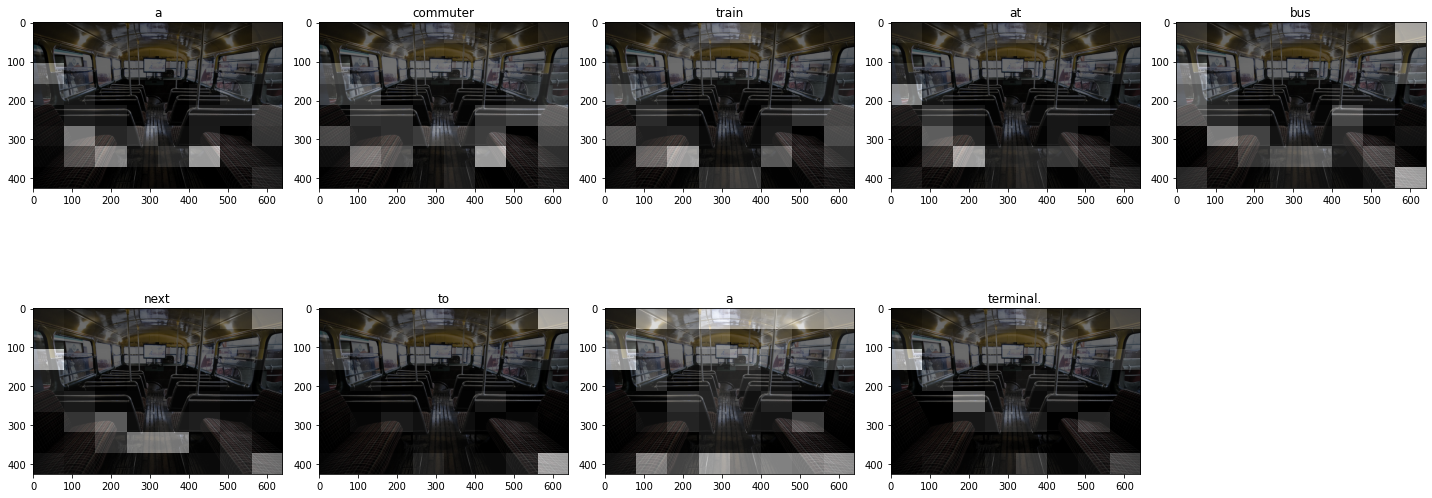

In [ ]:
# captions on the test set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
num = np.random.randint(0, len(img_name_val)/5)
test_references = []
for i in range(5):
   test_references.append(list_of_references[num][i].split())

image = img_name_val[num*5]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]]).split()

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index_train, index_to_word_train)

if result[-1] == "<end>":
    result.remove("<end>")

# if real_caption[0] == "<start>":
#     real_caption.remove("<start>")

rouge = Rouge()
list_of_hypotheses = [result]

print('Real Caption:', list_of_references[num][0])
print('Prediction Caption:', ' '.join(result))
print('Meteor: %f' % meteor_score(test_references, result))
print('Rouge: \n', rouge.get_scores(refs=list_of_references[num][0], hyps=' '.join(result), avg=True))
print('BLEU-1: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25)))
plot_attention(image, result, attention_plot)